In [2]:
import gc
import time
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['OMP_NUM_THREADS'] = '4'

path = 'data/'
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

print('started loading')

train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
#train_df = pd.read_csv(path+"train.csv", dtype=dtypes, skiprows = range(1, 131886954), usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])
train_df = pd.read_csv(path+"train_sample.csv", dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])
test_df = pd.read_csv(path+"test.csv", dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])

print('finished loading')

def prep_data(d):
    """
    print('hour, day, wday....')
    d['hour'] = pd.to_datetime(d.click_time).dt.hour.astype('uint8')
    d['day'] = pd.to_datetime(d.click_time).dt.day.astype('uint8')
    d['wday']  = pd.to_datetime(d.click_time).dt.dayofweek.astype('uint8')
    print('grouping by ip-day-hour combination....')
    gp = d[['ip','day','hour','channel']].groupby(by=['ip','day','hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'qty'})
    d = d.merge(gp, on=['ip','day','hour'], how='left')
    del gp; gc.collect()
    print('group by ip-app combination....')
    gp = d[['ip','app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})
    d = d.merge(gp, on=['ip','app'], how='left')
    del gp; gc.collect()
    print('group by ip-app-os combination....')
    gp = d[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 'os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_os_count'})
    d = d.merge(gp, on=['ip','app', 'os'], how='left')
    del gp; gc.collect()
    print("vars and data type....")
    d['qty'] = d['qty'].astype('uint16')
    d['ip_app_count'] = d['ip_app_count'].astype('uint16')
    d['ip_app_os_count'] = d['ip_app_os_count'].astype('uint16')
    """
    print("label encoding....")
    from sklearn.preprocessing import LabelEncoder
    #d[['app','device','os', 'channel', 'hour', 'day', 'wday']].apply(LabelEncoder().fit_transform)
    d[['app','device','os', 'channel']].apply(LabelEncoder().fit_transform)
    print('dropping')
    d.drop(['click_time', 'ip'], 1, inplace=True)
    
    return d

train_df = prep_data(train_df)
test_df = prep_data(test_df)
print("finished")

C:\Users\MLUSER\AppData\Local\conda\conda\envs\my_root\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


started loading
finished loading
label encoding....
dropping
label encoding....
dropping
finished


In [59]:
RANDOM_SEED = 1
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

X_train, X_test = train_test_split(train_df, test_size=0.4, random_state=RANDOM_SEED)

#print X_train['is_attributed'].sum()/float(X_train.shape[0])
#print X_test['is_attributed'].sum()/float(X_test.shape[0])

y_train = X_train['is_attributed']
X_train = X_train.drop(['is_attributed'], axis=1)
y_test = X_test['is_attributed']
X_test = X_test.drop(['is_attributed'], axis=1)


from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks, EditedNearestNeighbours

X_over_train, y_over_train = SMOTE(random_state=10).fit_sample(X_train, y_train)
X_under_train, y_under_train = RandomUnderSampler(random_state=10).fit_sample(X_train, y_train)

In [104]:
from sklearn.ensemble import RandomForestClassifier

#rf = RandomForestClassifier(max_depth=9, random_state=10)
#rf = RandomForestClassifier(n_estimators=12, max_depth=12, min_samples_leaf=50, \
#                            max_features=0.5, bootstrap=False, n_jobs=-1, random_state=10) #0.9627 now
rf = RandomForestClassifier(n_estimators=15, max_depth=10, min_samples_leaf=20, \
                            max_features=0.7, bootstrap=False, n_jobs=-1, random_state=10)
#rf = RandomForestClassifier(n_estimators=100, max_depth=9, min_samples_leaf=40, \
#                            max_features=0.6, bootstrap=False, n_jobs=-1, random_state=10)
#rf = RandomForestClassifier(n_estimators=50, max_depth=6, min_samples_leaf=1, \
#                            max_features=0.6, bootstrap=False, n_jobs=-1, random_state=10)
#rf.fit(X_train, y_train)
rf.fit(X_over_train, y_over_train)
#rf.fit(X_under_train, y_under_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=10, max_features=0.7, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=-1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [105]:
predictions = rf.predict_proba(X_test)
print predictions

[[  9.99165472e-01   8.34528252e-04]
 [  9.99009210e-01   9.90789643e-04]
 [  9.68318339e-01   3.16816614e-02]
 ..., 
 [  9.95735514e-01   4.26448576e-03]
 [  9.91283870e-01   8.71613005e-03]
 [  9.99523665e-01   4.76335401e-04]]


In [106]:
def convert_preds(raw_preds):
    #raw_preds = np.where(raw_preds > 0.99, 1, 0)
    preds = []
    for p in raw_preds:
        preds.append(1 - p[0])
    
    return preds

In [107]:
val_preds = convert_preds(predictions)

In [108]:
max(val_preds)

0.99466141911647687

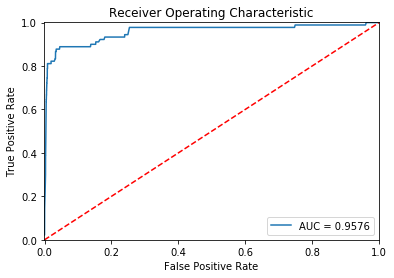

In [109]:
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(y_test, val_preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [102]:
print test_df.head()
ids = test_df['click_id']
test_df.drop('click_id', axis=1, inplace=True)
predictions = rf.predict_proba(test_df)

   click_id  app  device  os  channel
0         0    9       1   3      107
1         1    9       1   3      466
2         2   21       1  19      128
3         3   15       1  13      111
4         4   12       1  13      328


In [103]:
sub_preds = convert_preds(predictions)
sub = pd.DataFrame()
sub['click_id'] = ids
sub['is_attributed'] = sub_preds
print sub.shape
sub.to_csv('rf_sub.csv', index=False)

(18790469, 2)


In [27]:
print (sub.head())

   click_id  is_attributed
0         0       0.013905
1         1       0.002466
2         2       0.000000
3         3       0.031881
4         4       0.002094
